# FateCompass - basics using RNA velocity

Here you will be guided through the basics of how to implement the FateCompass pipeline. 

First of all, FateCompass has two main inputs:

1. pre-preprocessed anndata object with annotated cell types and  
a. **RNA velocities – in case you have a coherent profile**, or  
b. prior knowledge on initial and final fates  
2. binding sites matrix. We provide pre-computed binding sites matrices for human and mouse using computationally predicted binding sites from the [SwissRegulon](https://swissregulon.unibas.ch/sr/) database.

This example is applied to endocrine development in the pancreas. **In this dataset, there is a coherent velocity profile pointing towards the four major final fates $\alpha$, $\beta$, $\delta$, and $\epsilon$ -cells**. See [here](https://scvelo.readthedocs.io/scvelo.datasets.pancreas/) for more details.  

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

In [2]:
scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

%matplotlib inline

### Load data 

1. Annotated AnnData object  

**FateCompass** expects annotations of at least the cell types (clustering). For downstream pre-processing we advise to use the guidelines of [scanpy](https://scanpy.readthedocs.io/en/stable/api.html#).

In [3]:
adata = scv.read('data/Pancreas/endocrinogenesis_day15_velo.h5ad', cache=True)
adata

AnnData object with n_obs × n_vars = 3696 × 7018
    obs: 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'velocity_genes'
    uns: 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

2. Binding site matrix  

This consist of a table where the columns are the TFs or motifs and the rows are the genes. Hence, each entry $n_{ij}$ corresponds to the binding sites of the TF $j$ in the regulatory region of the gene $j$. It can be read as a pandas data frame where the index are the gene names and the columns the TF names.  

In [4]:
#filename = '/shared/space2/molina/Data/binding_sites/mouse/mm10_BSperFamily.csv'
filename = 'data/binding_sites/binding_sites_mouse.csv'
bs = pd.read_csv(filename, index_col=0, header=0,sep=';')
bs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7018 entries, Mrpl15 to Ddx3y
Columns: 181 entries, Ahr to Zkscan3
dtypes: float64(181)
memory usage: 9.7+ MB


### Data pre-processing for RNA velocity computation and TF activity estimation

The scVelo function `scv.pp.filter_and_normalize` essentially filters, normalize and log-transform the data. If X is already preprocessed from former analysis, it will not be touched.  

**Note:** Considering a smaller set of highly variable genes (`n_top_genes=2000`) can speed up RNA velocity estimation but it can diminish TF activity estimations, we suggest using`n_top_genes=10000`. 

In [ ]:
# SKIP this if your anndata object is already pre-processed!!!
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=10000)
adata

### RNA velocity computation using scVelo

The following commands follow the scVelo basics. For more details go [here](https://scvelo.readthedocs.io/VelocityBasics/#)

In [ ]:
# SKIP this if your anndata object already has the velocities stored!!!!
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

### Nearest neighbor graph representing the phenotypic manifold

The **FateCompass** function `graph_fatecompass` builds a nearest neighbor graph in a reduced space.  
For more detailed information about the graph, follow the **advanced mode tutorial**.  

The inputs for the `graph_fatecompass` function are:  
1. **adata**: pre-proccessed and log normalized anndata object. 
2. **mode**: which drift will you use for the transition probabilities. In this notebook we used **'velocity'**.
3. **basis**: dimensionality reduction method to compute the nearest neighbor graph.
4. **components**: number of components to compute the nearest neighbor graph. 
5. **n_neighbors**: number of nearest neighbors.  

The output is the neighbor graph ('distances_fatecompass' and 'indices_fatecompass') stored in the anndata object: `adata.obsm`.

In [5]:
mode = 'velocity'
basis = 'umap'
components = 10
n_neighbors = 10

In [6]:
from fatecompass import graph_fatecompass

graph_fatecompass(adata, mode, basis, components, n_neighbors)


Computing dimensions in reduced space

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
-->added
'dimensions_fatecompass' and 'velo_dimensions_fatecompass', dimension and embedded velocities (adata.obsm)

Finished -->added
 'indices_fatecompass', knn graph (adata.obsm)



### Cell-fate decision dynamics using RNA velocity as direction of differentiation

The **FateCompass** function `rna_velocity_driven_stochastic_simulations` infers transition probabilities using a Markov process on a network, limiting the transitions to the observable states (cells). The kernel has the following form:  

\begin{equation}
\Pi_{ij} = \frac{1}{z_i (2 \pi D \Delta t )^{1/2}} exp\left(-\frac{(\xi_{ij} - V(x_i)\Delta t)^2}{2D \Delta t}\right)  
\end{equation}  

where $\Pi_{ij}$ is the probability to jump from state $i$ to state $j$, $\xi_{ij}$ is the distance between the current state and the next possible state, $V(x_i)$ is the velocity vector of the current state, $\Delta t$ is the time step, $D$ is the diffusion coefficient, and $z_i = \sum_j \Pi_{ij}$ is a row normalization factor.  

$D$ and $\Delta t$ are fitted heuristically based on the number of neighbors. Shortly, we set $\Delta t$ such that on average the number of nearest neighbors can be reached, and $D$ such that the average number of connections is twice the number of nearest neighbors. Then, using the transition probabilities, the **FateCompass** function `rna_velocity_driven_stochastic_simulations` performs stochastic simulations using a Monte Carlo sampling algorithm.  

The inputs for the `rna_velocity_driven_stochastic_simulations` function are:  
1. **adata**: pre-proccessed and log normalized anndata object. 
2. **root**: where to start the stochastic simulations. For this, provide information about the cluster of cells that is **less** differentiated.
3. **cell_types_key**:
4. **numiter**: number of iterations for the Monte Carlo sampling algortihm. Default: 1e3.
5. **numsimcells**: number of trajectories to simulate. Default: 1e3.  
6. **cutoff**:
7. **D0**:

The output are the differentiation trajectories ('states' and 'num_trajectories') stored in the anndata object: `adata.uns`.

In [7]:
root = np.flatnonzero(adata.obs['clusters'] == 'Ductal')[0]
root = 335
numiter = 2000
numsimcells = 1000

In [8]:
from fatecompass import rna_velocity_driven_stochastic_simulations 
#12:23 - 13:08
rna_velocity_driven_stochastic_simulations(adata, root=root, cell_types_key='clusters',
                                           numiter=numiter, 
                                           numsimcells=numsimcells)


Fitted value of D:  [0.11635781] 
Fitted value of dt:  5.191400870347007

*****Transition probabilities successfully computed.*****


*****Performing stochastic simulations.*****

sim cell	 0
sim cell	 100
sim cell	 200
sim cell	 300
sim cell	 400
sim cell	 500
sim cell	 600
sim cell	 700
sim cell	 800
sim cell	 900

Finished -->added
 'states' and 'num_trajectories', stochastic trajectories (adata.uns)



The number of trajectories ending in the given fates can be checked in: `adata.uns['num_trajectories']`

In [9]:
adata.uns['num_trajectories']

{'Ductal': 67,
 'Ngn3 low EP': 198,
 'Ngn3 high EP': 13,
 'Pre-endocrine': 12,
 'Beta': 425,
 'Alpha': 117,
 'Delta': 0,
 'Epsilon': 168}

The **stochastic trajectories** can be visualized using the **FateCompass** function `plot_sim_cell`. This will provide the trajectory of a given simulated cell.  

The inputs of the `plot_sim_cell` function are:  
1. **adata**:
2. **basis**:
3. **simulated_cell**:
4. **color**: 

In [10]:
mycell = adata.uns['states'][:,3]

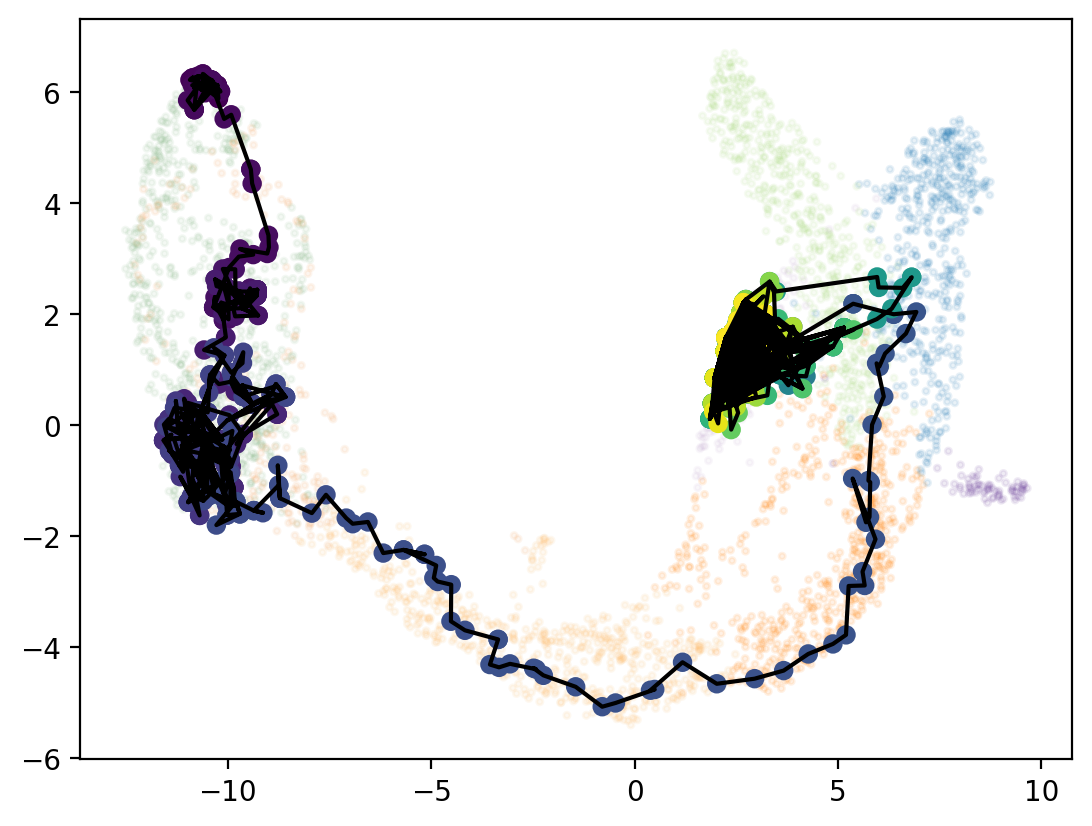

In [11]:
from fatecompass import plot_sim_cell
plot_sim_cell(adata, 'umap', mycell, color = 'clusters')

The FateCompass function `fate_probabilities` estimates the probability of each observation (cell) of ending in a given final fate by counting how often a random walk that visits cell $i$ ends in any of the terminal index sinks.  

The inputs of the `fate_probabilities` function are: 
1. **adata**:
2. **cell_types_key**:

In [13]:
from fatecompass import fate_probabilities
fate_probabilities(adata, cell_types_key='clusters')

The fate probabilities can be visualized using the FateCompass function `plot_fate_pbb`. This will output an embedding color with a gradient of probability for the selected final fate.  

The inputs of the `plot_fate_pbb` function are:  
1. **adata**:
2. **basis**: 
3. **color**: 

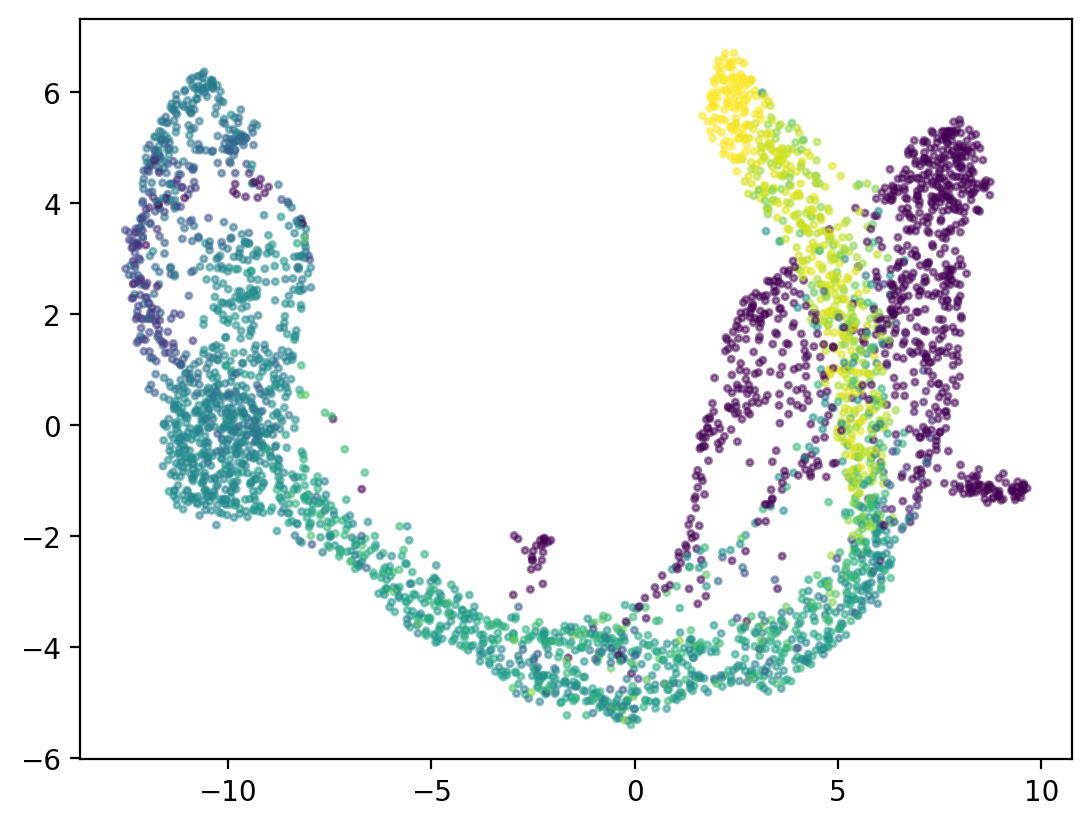

In [15]:
from fatecompass import plot_fate_pbb
plot_fate_pbb(adata, basis='umap', color='Beta')

### TF activity estimation using a linear model of gene regulation 

The FateCompass function `tf_activities` fits TF activities from the gene expression data using the following linear model of gene regulation:  

\begin{equation}
E_{gc} = \sum_f(N_{gf} * A_{fc}) + noise     
\end{equation}

where $E_{gc}$ is the gene expression matrix, $N_{gf}$ is the binding sites matrix –each entry represents the probability of binding of the TF $f$ in the promoter region of the gene $g$–, and $A_{fc}$ is the TF activity matrix. To account for the noise, the function implements a data diffusion regularization, where the main assumption is that the activity of similar cells should be similar. Then, the learned activities are diffused in the nearest neighbor graph. The diffusion time is fitted using a cross-validation scheme. Finally, the distribution of the TF activities is learned using a bootstrapping strategy.  
<br>

The inputs for the `tf_activities` function are: 
1. **adata**: pre-proccessed and log normalized anndata object
2. **bs**: binding sites matrix. Data frame with rows equal genes and columns equal TFs. 
3. **tolerance**: minimum difference between the test and training datasets used in the cross-validation scheme. Default 1e-2.  

The output are the TF activies and their distribution ('tf_activities' and 'tf_activities_distribution') stored in the anndata object: `adata.uns`  


In [16]:
from fatecompass import tf_activities

tf_activities(adata, bs, tolerance = 4.5e-3)

Number of cells: 3696
Number of genes: 7018
Number of motifs: 181
Normalized binding site matrix [genes x motifs]: (7018, 181)
Cell- and Gene- Normalized expression matrix [cells x genes]: (3696, 7018)

Initializing cross-validation scheme to fit the value of t for data diffusion regularization

Diffusion time:  0 	 Residual:  0.01095193246681829
Diffusion time:  1 	 Residual:  0.01095193246681829
Diffusion time:  2 	 Residual:  0.007384511105448341
Diffusion time:  3 	 Residual:  0.005750966461149323
Diffusion time:  4 	 Residual:  0.004970910452860133
Diffusion time:  5 	 Residual:  0.0045794987592024106

Initializing bootstrapping to build the distribution of the estimate for the TF activities.

sample	 0
sample	 10
sample	 20
sample	 30
sample	 40
sample	 50
sample	 60
sample	 70
sample	 80
sample	 90

Finished -->added
 'tf_activities' and 'tf_activities_distribution', TF activities regularized (adata.uns)



The TF activities can be visualized using the basic plotting functions of scanpy. For doing that, add to `adata.obs` the value of the TF activities you wish to visualize.  

To check the complete list of TF family names run: `list(bs.columns)`

In [17]:
adata.obs['nkx6-1_act'] = adata.uns['tf_activities'].loc[:,'Nkx6-1_Evx1_Hesx1']
adata.obs['arx_act'] = adata.uns['tf_activities'].loc[:,'Hoxc4_Arx_Otp_Esx1_Phox2b']
adata.obs['neurod1_act'] = adata.uns['tf_activities'].loc[:,'Neurod1']
adata.obs['arntl_act'] = adata.uns['tf_activities'].loc[:,'Arntl_Tfe3_Mlx_Mitf_Mlxipl_Tfec']

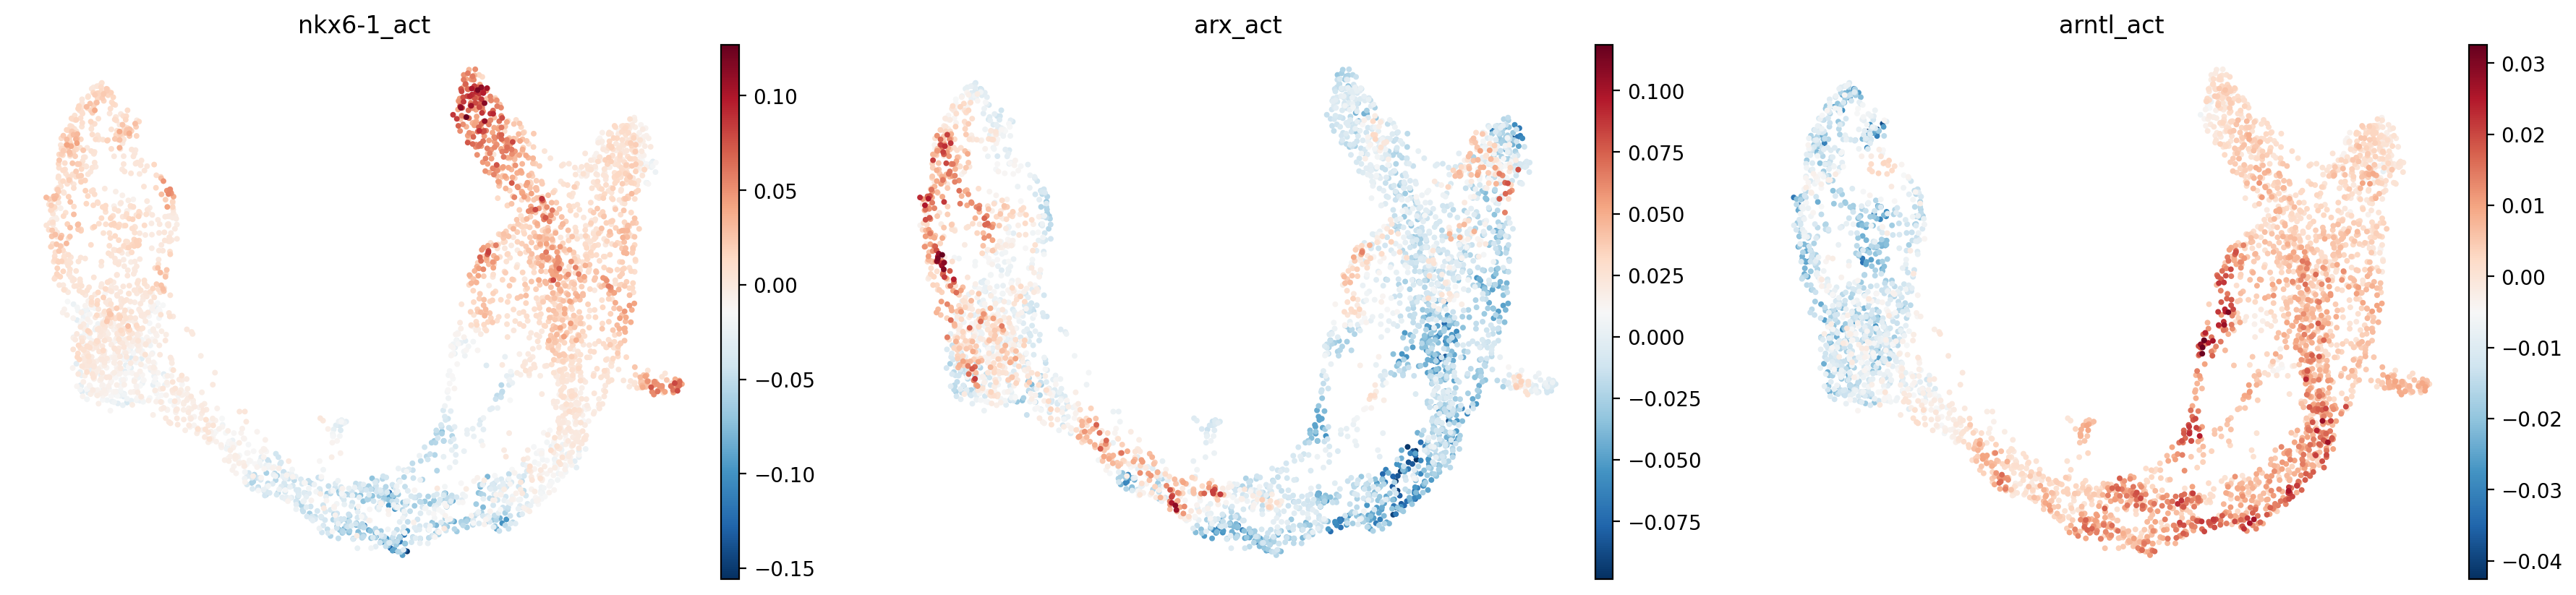

In [18]:
sc.pl.umap(adata, color=['nkx6-1_act','arx_act','arntl_act'], frameon=False, cmap='RdBu_r')

The activity of **all** the TFs can be visualized using `clustermap` from the *seaborn* library as follows:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df=adata.uns['tf_activities']
df['clusters']=adata.obs['clusters'].values

clusters = df['clusters']
keys = adata.obs['clusters'].cat.categories
values = adata.uns['clusters_colors']

lut1 = {keys[i]: values[i] for i in range(len(keys))}
col_colors1 = clusters.map(lut1)

df = df.drop(['clusters'], axis=1)

In [ ]:
sns.set(font_scale=1.0)
g=sns.clustermap(df.T,col_cluster=True,row_cluster=True, col_colors=col_colors1,
                 cmap='RdBu_r',z_score=0,yticklabels=True,figsize=(20, 30))
ax = g.ax_heatmap
g.cax.set_visible(False)
g.ax_cbar.set_visible(True,)
ax.set_xticks([])
ax.set_xticklabels([])
plt.show()

### Average gene expression and activity profiles over stochastic trajectories

The **FateCompass** function `avg_profiles_over_trajectories` uses the stochactic tracjectories previously generated (stored in `adata.uns['states']`) to approximate the expected value of the mean and the standard error of the mean (sem).  

The inputs for `avg_profiles_over_trajectories` are:  
1. **adata**: pre-proccessed and log normalized anndata object.  
2. **cell_types_key**: key of the observations clustering to consider.  

The outputs are the **mean** and **sem** of the gene expression ('mean_E', and 'sem_E') and activity ('mean_A', and 'sem_S') profiles stored in the anndata object: `adata.uns`.

In [19]:
from fatecompass import avg_profiles_over_trajectories
avg_profiles_over_trajectories(adata, cell_types_key='clusters')
# ~7min

sim cell	 0
sim cell	 100
sim cell	 200
sim cell	 300
sim cell	 400
sim cell	 500
sim cell	 600
sim cell	 700
sim cell	 800
sim cell	 900

Finished --> added
 'mean_E' and 'sem_E', average gene expression profiles over trajectories (adata.uns)
 'mean_A' and 'sem_A', average TF activity profiles over trajectories (adata.uns)



The average gene expression and activity profiles can be visualized over the stochastic trajectories using the **FateCompass** function `plot_trajectory`.  

The inputs for the `plot_trajectory` are:  
1. **adata**: pre-proccessed and log normalized anndata object. 
2. **mode**: which average profile to plot, it can be **'mRNA'** or **'activity'**.  
3. **variable**: **gene** (in 'mRNA' mode) or **motif** (in 'activity' mode) for which you want to plot the trajectory.  
4. **cell_types_key**: key of the observations clustering to consider.  
5. **trajectory**: over which trajectory you wish to plot the profile of the variable of interest. It must be a key from cell_types_key.  


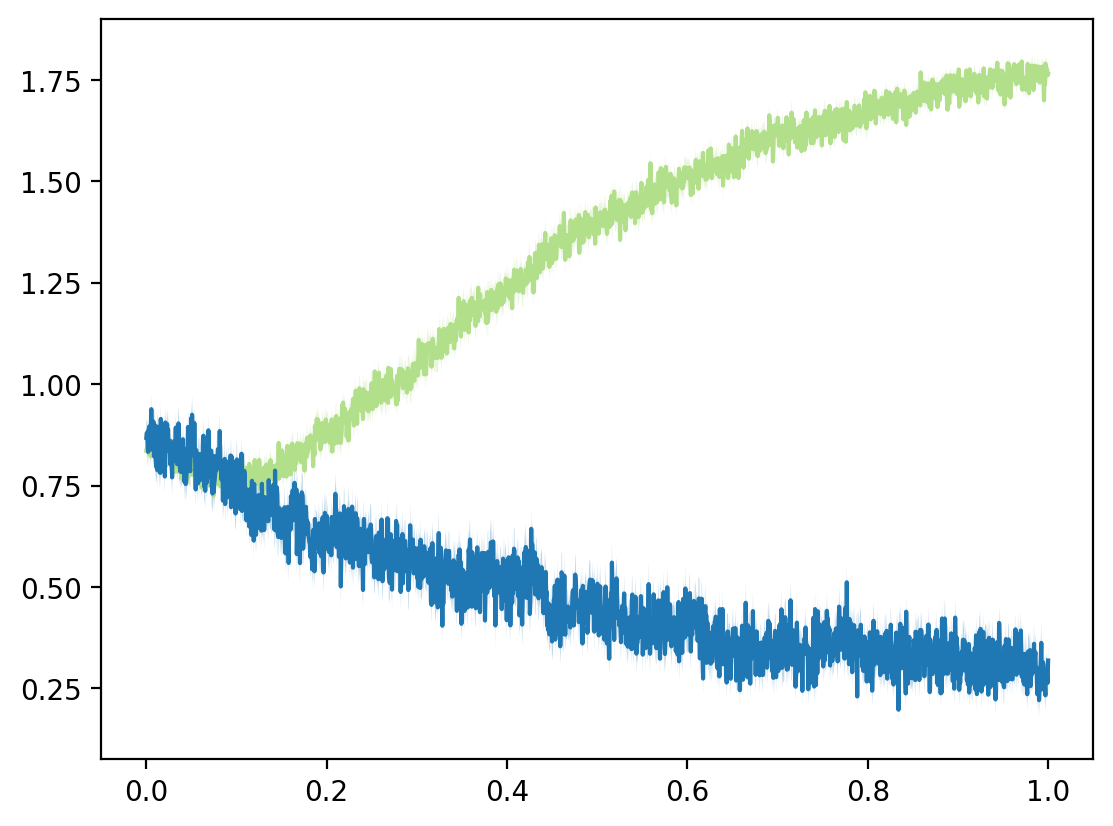

In [20]:
from fatecompass import plot_trajectory
plot_trajectory(adata, mode='mRNA' ,variable=['Nkx6-1'], 
                cell_types_key='clusters', trajectory=['Beta','Alpha'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


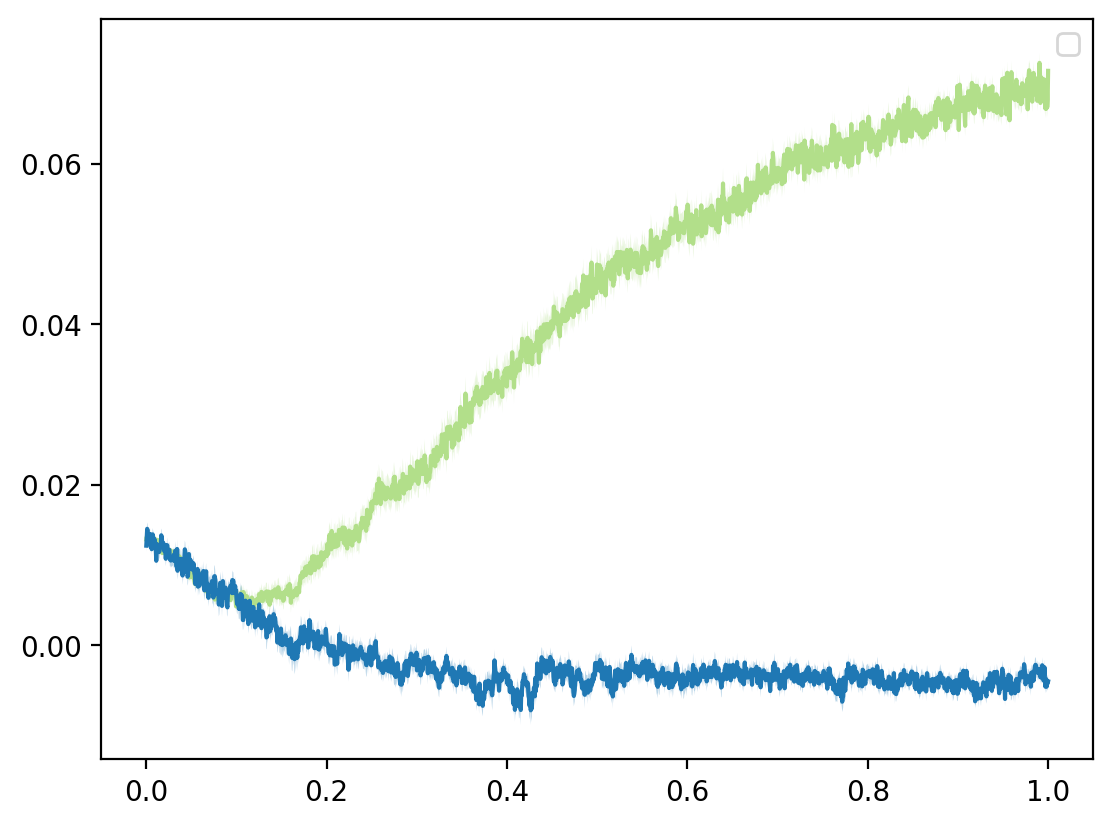

In [21]:
plot_trajectory(adata, mode='activity' ,variable=['Nkx6-1_Evx1_Hesx1'], 
                cell_types_key='clusters', trajectory=['Beta','Alpha'])

In [ ]:
plot_trajectory(adata, mode='activity' ,variable=['Hoxc4_Arx_Otp_Esx1_Phox2b'], 
                cell_types_key='clusters', trajectory=['Beta','Alpha'])

### Differential TF activity analysis  

The **FateCompass** function `differential_tf_activity` computes three criteria to guide the identification of lineage-specific regulators. The criteria are:  

1. **z-score**: it can be interpreted as the number of standard deviations that the activity of a TF is away from its average of zero corrected by the precision of the estimation (a.k.a. error bar).  
2. **Variability over time**: it can be interpreted ad the rate of change of the TF activity over simulated time. FateCompass gets a proxy of this by computing the standard deviation of the TF activity over the stochastic trajectories.  
3. **Dynamic correlation**: this is the cross-correlation between the TF activity and the average gene expression profile of the TF transcript. 

The inputs for `differential_tf_activity` are:  
1. **adata**: pre-proccessed and log normalized anndata object.  
2. **cell_types_key**: key of the observations clustering to consider.  

The outputs are the 'z_score', 'std_tf_time', 'cross_corr' and 'time_lags' stored in the anndata object: `adata.uns`.

In [22]:
from fatecompass import differential_tf_activity
differential_tf_activity(adata, 'clusters')


 z-score --> computed

variability over time --> computed

dynamical correlation --> computed



To identify lineage-specific regulators we suggest to explore the **density distribution of the some of criteria described above**; this exploration will guide the setting of thresholds for filtering. Below we provide examples of how to do the exploration.  

The **FateCompass** function `ksdensity_fatecompass` allows to explore two criteria: z-score and variability over time:  

1. The **z-score** is computed TF-wise, by plotting the density distribution we can visualize what is the most common value and the range. We suggest to set a threshold for the z-score higher than or equal to the most common value.  
2. The **variability over time** is computed TF-wise for **every differentiation trajectory**. Similarly to the z-score, we can visualize the density distribution for the different trajectories. We suggest to set a threshold for the variability over time higher than or equal to the mean of the most common values for the different trajectories.  

The inputs for `ksdensity_fatecompass` are:  
1. **adata**: pre-proccessed and log normalized anndata object. 
2. **criteria**: criteria to plot `['z_score','std_tf_time']`.  
3. **cell_types_key**: key of the observations clustering to consider. 
4. **trajectory**: for which trajectories you wish to plot the density distribution. It must be a key from cell_types_key.  

The output is a plot with the density distribution and of the selected criteria, i.e., `['z_score','std_tf_time']`, and the variability over time for the selected trajectories. Also, a red vertical line indicating the suggested threshold for each criterion. 

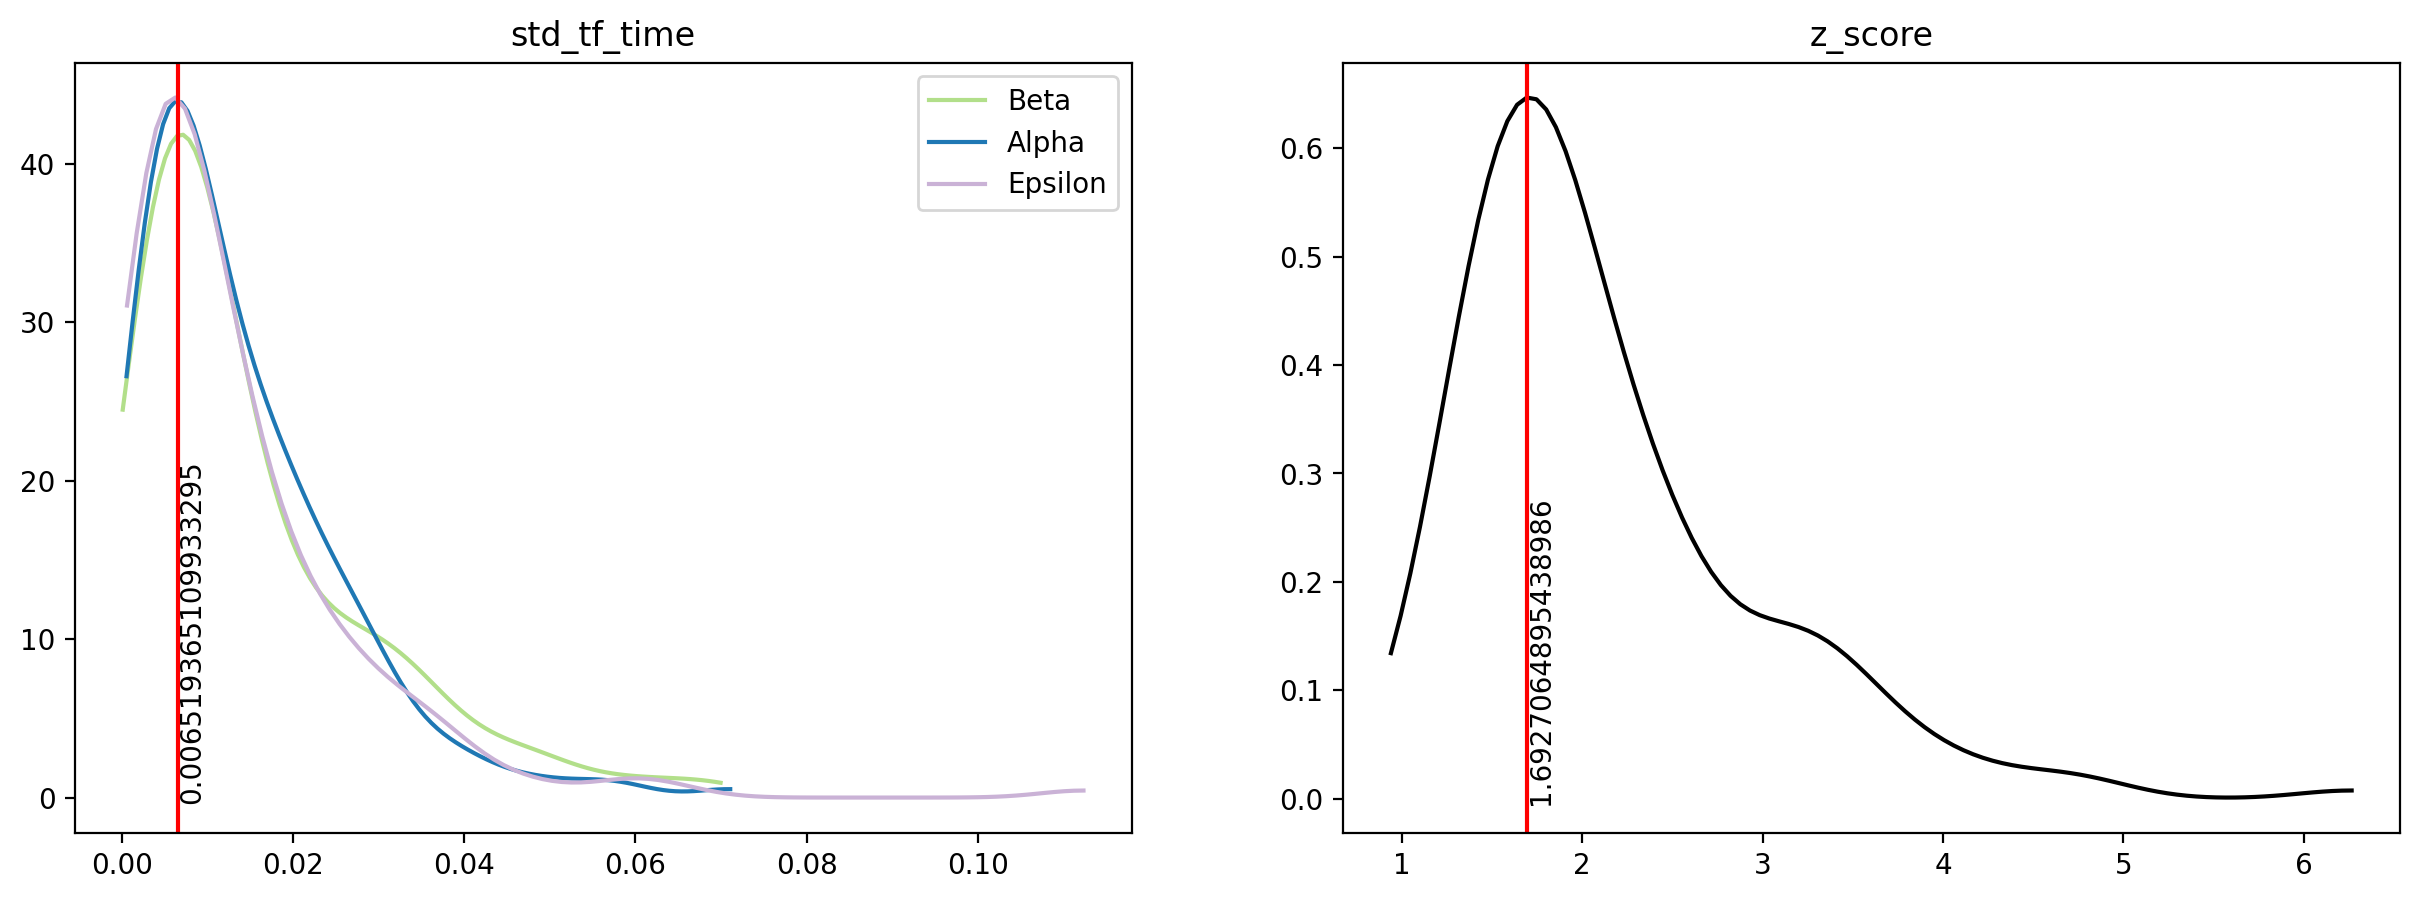

In [23]:
from fatecompass import ksdensity_fatecompass
ksdensity_fatecompass(adata, criterion=['std_tf_time','z_score'], cell_types_key='clusters', 
                      trajectory=['Beta','Alpha','Epsilon'])

To perform the **filtering and get the results in a data frame** the **FateCompass** function `get_df_differential_tf_activity` formats the results in a table.  

The inputs for the `get_df_differential_tf_activity` function are:  
1. **adata**: pre-proccessed and log normalized anndata object. 
2. **fates**: differentiation trajectories of interest. These keys must belong to the key of the observations clustering. 
3. **thresholds**: thresholds to perform the filtering and fate assignment in a dictionary format. Below there is an example of how to create the dictionary.  

The output is a pandas data frame that can be exported, where the indices are the motif families, and the columns are:  
- TFs: each TF beloging to the respective motif family.  
- std_tf_time_*trajectory*: variability over time of the respective TF in the indicatated differentiation trajectory. This column will be present for each *trajectory*.  
- max_cross_corr_*trajectory*: value of maximum cross correlation between TF activity and expression of the TF mRNA. This column will be present for each *trajectory*.  
- time_max_cross_corr_*trajectory*: time lag at wich the maximum cross correlation occurs. This column will be present for each *trajectory*.  
- z_score: value of z-score. 
- FateCompass_prediction: Name of the differentiation trajectory for which FateCompass pipeline predicts a role based.  

In [24]:
thresholds = {'variability': 0.005, 'z_score': 1.5, 'correlation': 0.5}
thresholds

{'variability': 0.005, 'z_score': 1.5, 'correlation': 0.5}

In [25]:
from fatecompass import get_df_differential_tf_activity
df = get_df_differential_tf_activity(adata,fates=['Alpha','Beta'], 
                                     thresholds=thresholds)
df

,TFs,std_tf_time_Alpha,std_tf_time_Beta,max_cross_corr_Alpha,time_max_cross_corr_Alpha,max_cross_corr_Beta,time_max_cross_corr_Beta,z_score,FateCompass_prediction
Ahr,Ahr,0.007311,0.007202,0.808557,-1,0.939254,-4,2.422236,AlphaBeta
Arid3a,Arid3a,0.025580,0.007022,0.669322,0,0.467814,0,1.934293,Alpha
Arid5b,Arid5b,0.014516,0.004018,0.12851,1036,0.388322,-1525,1.349713,NaN
Arnt,Arnt,0.006168,0.013458,0.315368,-1184,0.2605,1334,1.225870,NaN
Arnt2,Arnt2,0.017593,0.027732,0.120743,1094,0.706445,0,1.939122,Beta
...,...,...,...,...,...,...,...,...,...
Zfhx3,Zfhx3,0.014816,0.033356,0.366829,-1544,0.389776,-1359,1.899623,NaN
Zfx_Mecp2,Zfx,0.000511,0.002127,0.258091,0,0.37382,-1369,1.782303,NaN
Zfx_Mecp2,Mecp2,0.000511,0.002127,0.593323,-306,0.781062,-1,1.782303,NaN
Zkscan1,Zkscan1,0.015734,0.009587,0.802276,3,0.462649,-100,2.030930,Alpha


In [ ]:
df.to_csv('output/mouse.txt', header=True, index=True, sep='\t')

In [ ]:
x = adata.uns['time_lags']['Beta']['Nkx6-1_Evx1_Hesx1']['Nkx6-1']
y = adata.uns['cross_corr']['Beta']['Nkx6-1_Evx1_Hesx1']['Nkx6-1']
plt.plot(x,y)

In [ ]:
x = adata.uns['time_lags']['Alpha']['Hoxc4_Arx_Otp_Esx1_Phox2b']['Arx']
y = adata.uns['cross_corr']['Alpha']['Hoxc4_Arx_Otp_Esx1_Phox2b']['Arx']
plt.plot(x,y)

In [ ]:
x = adata.uns['time_lags']['Beta']['Arntl_Tfe3_Mlx_Mitf_Mlxipl_Tfec']['Mlxipl']
y = adata.uns['cross_corr']['Beta']['Arntl_Tfe3_Mlx_Mitf_Mlxipl_Tfec']['Mlxipl']
plt.plot(x,y)